In [4]:
import sys
  
# append the path of the
# parent directory
sys.path.append("..")

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import json, csv
import mne
import scipy
import pandas
import copy
import mbt_pyspt as mbt
from mbt_pyspt.models.eegdata import EEGData
from mbt_pyspt.models.mybraineegdata import MyBrainEEGData
from mbt_pyspt.modules.preprocessingflow import PreprocessingFlow
from mbt_pyspt.modules.featuresextractionflow import FeaturesExtractionFlow
from utils.em_data_loader import generate_participants_datasets, generate_participants_events, load_dataset
from utils.em_plotting import plot_annotations, plot_avg_annotations, plot_study, plot_signal, plot_trial_annotations, plot_avg_annotations_all_participants, plot_linear_regression
from preprocessing.em_preprocessing import find_none_parameters, copy_annotations_to_ec, participant_avg_annotation_windows, preprocess_em_participant, compute_participant_features
from preprocessing.em_qi_cleaner import qi_data_removal
from classification.em_linear_regression import lin_regression, valence_and_neuromarker, arousal_and_neuromarker, liking_familiarity_correlation
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection  import train_test_split
from pprint import pprint
from statistics import mean
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window

print("All libraries successfully loaded!")

All libraries successfully loaded!


### Splitting Data
This snippets launches the splitting pipeline that transforms the original datasets in an easy-to-manage set containing only the eeg data and the annotations divided by trials for each participant. Warning: this will overwrite all existing datasets.

In [2]:
# Prepare all the datasets
path_eo_ec = '../data/em_ca_experiment_slim/1EOEC'
path_ec_eo = '../data/em_ca_experiment_slim/2ECEO'
excluded = ['s050702', 's020702', 's060702', 's250603', 's220603', 's220604' 's170603', 's050703', 's050705']
eo_ec_folders = []
ec_eo_folders = []
eeg_folder = 'eeg_raw'
metadata_folder = 'metadata'
physio_folder = 'physio_raw'

for directory in os.listdir(path_eo_ec):
    if directory != 'excluded':
        eo_ec_folders.append(directory)
for directory in os.listdir(path_ec_eo):
    if directory != 'excluded':
        ec_eo_folders.append(directory)

generate_participants_datasets(path_eo_ec, eo_ec_folders, '1EOEC')
generate_participants_datasets(path_ec_eo, ec_eo_folders, '2ECEO')

print("All datasets prepared")

Processing participant s010701
s010701 ...loaded!
s010701 ...generated events!
s010701 ...split data part 1!
s010701 ...split data part 2!
s010701...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s010701/s010701_prepared.json !
Processing participant s010704
s010704 ...loaded!
s010704 ...generated events!
s010704 ...split data part 1!
s010704 ...split data part 2!
s010704...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s010704/s010704_prepared.json !
Processing participant s020701
s020701 ...loaded!
s020701 ...generated events!
s020701 ...split data part 1!
s020701 ...split data part 2!
s020701...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s020701/s020701_prepared.json !
Processing participant s020702
s020702 ...loaded!
s020702 ...generated events!
s020702 ...split data part 1!
s020702 ...split data part 2!
s020702...merged all the data and saved in ../data/em_ca_experiment_slim/1EOEC/s020702/s020702_prepared.json !


s280601 ...loaded!
s280601 ...generated events!
s280601 ...split data part 1!
s280601 ...split data part 2!
s280601...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s280601/s280601_prepared.json !
Processing participant s290601
s290601 ...loaded!
s290601 ...generated events!
s290601 ...split data part 1!
s290601 ...split data part 2!
s290601...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290601/s290601_prepared.json !
Processing participant s290603
s290603 ...loaded!
s290603 ...generated events!
s290603 ...split data part 1!
s290603 ...split data part 2!
s290603...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290603/s290603_prepared.json !
Processing participant s290605
s290605 ...loaded!
s290605 ...generated events!
s290605 ...split data part 1!
s290605 ...split data part 2!
s290605...merged all the data and saved in ../data/em_ca_experiment_slim/2ECEO/s290605/s290605_prepared.json !
Processing participant s300604


### Data Loading
Loads the entire dataset in memory and saves the participants keys in an array for later use. Warning: computation is slow and time consuming, use only when necessary.

In [5]:
# Load the entire Emotion-Music dataset
dataset = load_dataset()
participants = dataset.keys()
print(participants)

dict_keys(['s010701', 's010702', 's010703', 's010704', 's020701', 's020702', 's020703', 's020704', 's050701', 's050702', 's050704', 's060703', 's070701', 's070702', 's170601', 's210602', 's220602', 's230602', 's230603', 's230604', 's240601', 's240602', 's240604', 's250601', 's250602', 's250604', 's260601', 's260602', 's280601', 's280603', 's280604', 's290601', 's290602', 's290603', 's290604', 's290605', 's300602', 's300604'])


### Preprocessing 
This code snippet runs the preprocessing pipeline on the whole dataset. Warning: computation is slow and time consuming, use only when necessary.

In [42]:
# Copy the dataset to avoid pre-processing again when data get contaminated
prep_dataset = copy.deepcopy(dataset)


In [43]:
list_pp = [
    #('notch_filter', {"freqs": [50,100]}),
    #('filter_mne', { "l_freq": 0.01, "h_freq": 30}),
    ('remove_dc_sec_by_sec', None), 
    #('median_filter', None),
    #('sliding_split_eeg_data', { 'buf': 5, 'sliding_step': 1}),
    #('interpolate_all_qc', None)
    ]

bpass_freqs = {'l_freq': 0.1, 'h_freq': 20}
notch_freqs = (50, 100)
qi_cleaning = True
trial_duration = 60 # in seconds
window_size = 10
qi_threshold = 0.40 # Since it's an average, a threshold of 0.5 would eliminate all trials with even small artifacts
allowed_loss = 30 # The percentage of data we are allowing to lose, more than that and the trial is flagged as rejected

In [ ]:
for participant_id in prep_dataset:
    prep_participant = preprocess_em_participant(prep_dataset[participant_id], list_pp, bpass_freqs=bpass_freqs, notch_freqs=notch_freqs, asr_cleaning=False)
    copy_annotations_to_ec(prep_participant)
    if qi_cleaning:
        qi_data_removal(prep_participant, trial_duration=trial_duration, qi_window_size=window_size, qi_threshold=qi_threshold, allowed_loss=allowed_loss)
    prep_dataset[participant_id] = prep_participant

Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 sampl

- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband

Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.26086956521739 60.26086956521739
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.625 59.625
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.630434782608695 59.630434782608695
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_3_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.680851063829785 59.680851063829785
Creating RawArray with float64 

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filt

- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_3_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.17391304347826 60.17391304347826
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_1_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.369565217391305 60.369565217391305
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_1_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.21739130434783 60.21739130434783
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filt

- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creatin

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filt

    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Percentage of pruned data: 16.67%
EC/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.95652173913044 59.95652173913044
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.6 60.6
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.06382978723404 60.06382978723404
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_2_B
Windows to remove [0 0


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

Clean seconds of EEG: 50.0
Clean seconds of annotations: 49.65909090909091 49.65909090909091
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Percentage of pruned data: 16.67%
EO/class_2_A
Windows to remove [1 0 0 0 0 0]
Clean seconds of EEG: 50.0
Clean seconds of annotations: 49.5 49.5
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Percentage of pruned data: 16.67%
EC/class_3_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.40909090909091 60.40909090909091
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_3_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.84090909090909 59.84090909090909
Creating RawArray with float64 data

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filt

- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

Ready.
Percentage of pruned data: 0.0%
EC/class_3_A
Windows to remove [1 1 1 0 0 1]
Clean seconds of EEG: 20.0
Clean seconds of annotations: 20.17241379310345 20.17241379310345
Creating RawArray with float64 data, n_channels=2, n_times=5000
    Range : 0 ... 4999 =      0.000 ...    19.996 secs
Ready.
Percentage of pruned data: 66.67%
Marked trial for rejection:  EC/class_3_A
EO/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.24561403508772 60.24561403508772
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_4_A
Windows to remove [1 0 1 1 1 1]
Clean seconds of EEG: 10.0
Clean seconds of annotations: 10.0 10.0
Creating RawArray with float64 data, n_channels=2, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Percentage of pruned data: 83.33%
Marked trial for rejection:  EC/class_4_A
EO/class_

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR 

Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, 

Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, 


Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters


Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =   

Ready.
Percentage of pruned data: 0.0%
EC/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.43103448275862 60.43103448275862
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.67796610169491 59.67796610169491
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.810344827586206 59.810344827586206
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_2_A
Windows to remove [1 0 0 0 0 0]
Clean seconds of EEG

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filt

- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_1_A
Windows to remove [0 1 0 1 1 1]
Clean seconds of EEG: 20.0
Clean seconds of annotations: 20.017241379310345 20.017241379310345
Creating RawArray with float64 data, n_channels=2, n_times=5000
    Range : 0 ... 4999 =      0.000 ...    19.996 secs
Ready.
Percentage of pruned data: 66.67%
Marked trial for rejection:  EC/class_1_A
EO/class_2_B
Windows to remove [1 1 1 0 0 0]
Clean seconds of EEG: 30.0
Clean seconds of annotations: 30.189655172413794 30.189655172413794
Creating RawArray with float64 data, n_channels=2, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
Percentage of pruned data: 50.0%
Marked trial for rejection:  EO/class_2_B
EC/class_2_A
Windows to remove [1 0 0 0 0 0]
Clean seconds of EEG: 50.0
Clean seconds of annotations: 50.224137931034484 50.224137931034484
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ...


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 149

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EC/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.56896551724138 59.56896551724138
Creating RawArray with 

Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =   

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.875 59.875
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.5625 60.5625
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_3_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.755102040816325 59.755102040816325
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_3_A
Windows to remove [0 0 0 0 0 0]
Clean 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
EO/class_3_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.46511627906977 60.46511627906977
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_3_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.19565217391305 60.19565217391305
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_1_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR 

Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, 

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_1_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.25 60.25
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_1_A
Windows to remove [0 0 1 0 0 0]
Clean seconds of EEG: 50.0
Clean seconds of annotations: 49.46666666666667 49.46666666666667
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Percentage of pruned data: 16.67%
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range 

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.04 60.04
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_2_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.92 59.92
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.64 59.64
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_3_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean secon


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cu

- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s

    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Settin


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.06122448979592 60.06122448979592
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_2_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.91836734693877 59.91836734693877
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.95918367346939 59.95918367346939
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_3_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.48979591836735 59.48979591836735
Creating RawA

- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filt


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_3_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.84782608695652 59.84782608695652
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.19565217391305 60.19565217391305
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.422222222222224 60.422222222222224
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transiti

- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000


Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin)

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_2_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.06818181818182 60.06818181818182
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.577777777777776 59.577777777777776
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_3_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.38636363636363 60.38636363636363
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

Percentage of pruned data: 0.0%
EO/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.479166666666664 60.479166666666664
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_4_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 60.12244897959184 60.12244897959184
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EO/class_4_A
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0
Clean seconds of annotations: 59.46938775510204 59.46938775510204
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Percentage of pruned data: 0.0%
EC/class_2_B
Windows to remove [0 0 0 0 0 0]
Clean seconds of EEG: 60.0



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 sec)

Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Setting up

### Removing bad quality data
Three methods:
- Removing all participants with more than X bad trials
- Skipping bad trials but keep the participant
- Both

In [ ]:
print("Original dataset", prep_dataset.keys(), '\n')
to_be_removed = []
for participant_id in prep_dataset:
    if prep_dataset[participant_id]['bad_trials'] > 8:
        print("Removing participant " + participant_id + " for poor data quality")
        to_be_removed.append(participant_id)
        
print("")
for key in to_be_removed:
    del prep_dataset[key]
print("Pruned dataset",prep_dataset.keys())

### Features Extraction
These snippets extracts features and save them in memory as sub entries of each trial

In [10]:
# Check the value of 'qi_cleaning' before launching
skip_qc = False # Change to True if you wanna count all the trials
sliding_step = window_size
n_windows = 60.0
split_data = {"buf": window_size, "sliding_step": sliding_step, "rest":False}
ff_list = [("get_normalized_power_alpha", {'samp_rate': 250, 'h_freq':13.0, 'l_freq': 7.0})] # , 'ht_freq': 40.0, 'lt_freq': 0.5
for participant_id in prep_dataset:
    print(participant_id, '--------------------------------------------------------------------------')
    compute_participant_features(prep_dataset[participant_id], ff_list=ff_list, split_data=split_data, cleaned_eeg=qi_cleaning, skip_qc=skip_qc)
    prep_dataset[participant_id] = participant_avg_annotation_windows(prep_dataset[participant_id], n_windows, w_size=window_size, cleaned_eeg=qi_cleaning, skip_qc=skip_qc)

s010701 --------------------------------------------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with fl

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
s220602 --------------------------------------------------------------------------
Creating RawArray 

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
s240602 --------------------------------------------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
s260602 --------------------------------------------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray 

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 .

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
s280604 --------------------------------------------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray 

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 .

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
s290604 --------------------------------------------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =

    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channe

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channel

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    49.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000

    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.


This snippet calculates average annotations for each participant for a specified amount of windows. Since each trial is 60 seconds, setting n_windows = 60 will calculate windows of 1 second

(24,) (24,) (12,) (12,)
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[-0.10483463]]
Mean squared error: 0.01
Coefficient of determination: -8.97


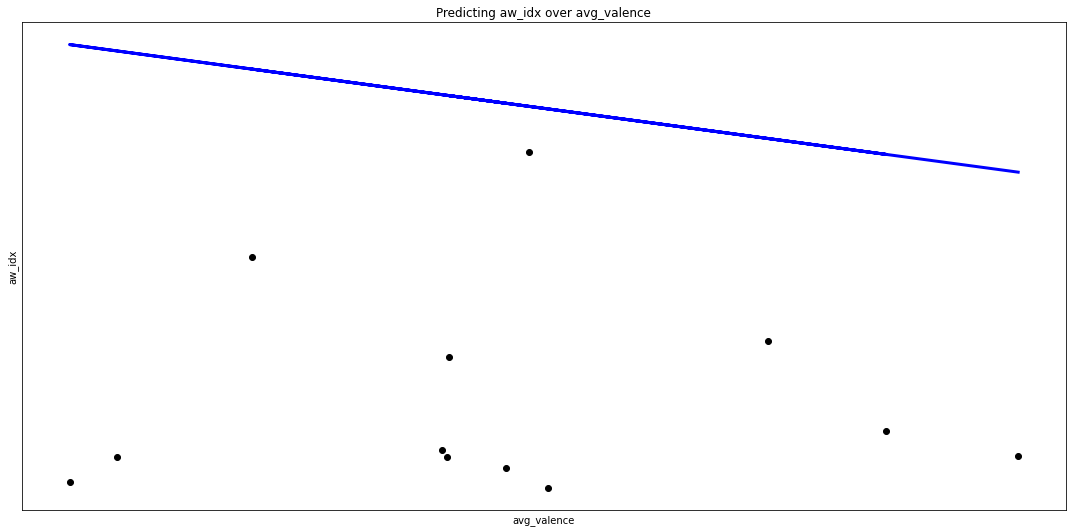

(0.006140474239907071, array([[-0.10483463]]), -8.972342763977165)

In [32]:
# AW Index and Valence
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-3] 
test_participants = participant_keys[-3:] 
skip_qc = False # Change to True if you wanna count all the trials

train_participants = ['s020701', 's010704'] 
test_participants = ['s010701']

plt.rcParams["figure.figsize"] = [15, 7.50]
independent = 'avg_valence'
dependent = 'aw_idx'
condition = 'EC'
trial_class = 'class_4_'
x_train, y_train, x_test, y_test = valence_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent, skip_qc=skip_qc)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

(18,) (18,) (12,) (12,)
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.24520954]]
Mean squared error: 0.00
Coefficient of determination: -0.44


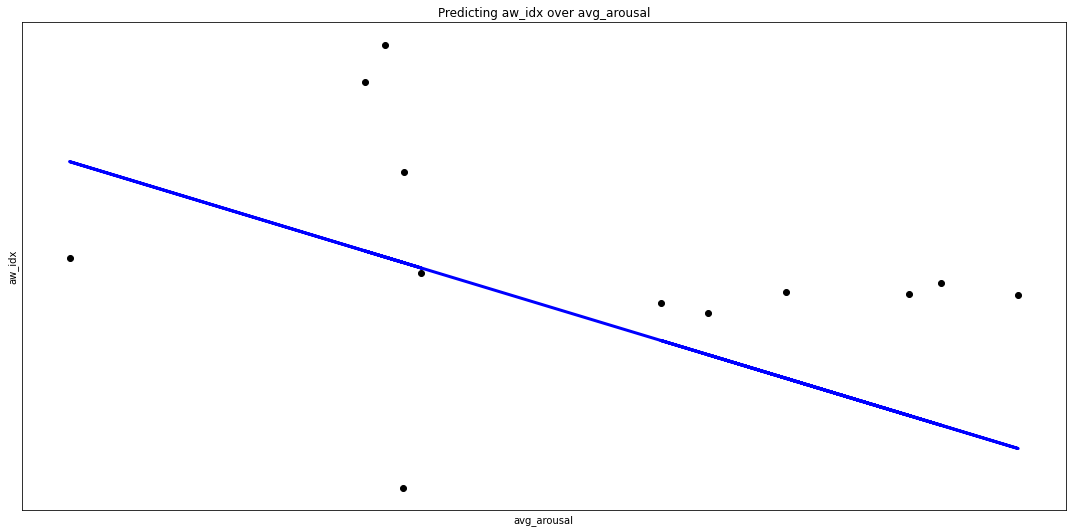

(0.0006976434225910355, array([[-0.24520954]]), -0.44281116032698686)

In [39]:
# AW Index and Arousal
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-3] 
test_participants = participant_keys[-3:] 
skip_qc = False # Change to True if you wanna count all the trials

train_participants = ['s020701', 's020703'] 
test_participants = ['s010701']

plt.rcParams["figure.figsize"] = [15, 7.50]
independent = 'avg_arousal'
dependent = 'aw_idx'
condition = 'EO'
trial_class = 'class_1_'
x_train, y_train, x_test, y_test = arousal_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent, skip_qc=skip_qc)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

In [24]:
find_none_parameters(prep_dataset, 'familiarity')

In [13]:
# Linear Regression for liking and familiarity
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)

train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

independent = 'familiarity'
dependent = 'liking'
condition = 'EC'
trial_class = 'class_3_'

x_train, y_train, x_test, y_test = liking_familiarity_correlation(prep_dataset, train_participants, test_participants, condition, trial_class, dependent, independent)


ValueError: invalid literal for int() with base 10: 'None'

In [19]:
# Single participant regression

X = np.array([])
y = np.array([])
independent = 'avg_valence'
dependent = 'aw_idx'
participant_id = 's010703'
neuromarker = 'aw_idx'
condition = 'EO'
trial_class = 'class_3_'

idx = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'A']['features'][neuromarker]
avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'A']['features']['avg_x']
X = np.concatenate((X, np.array(avg_valence)))
y = np.concatenate((y, np.array(idx)))

idx = prep_dataset[participant_id]['trials'][condition + '/' + trial_class + 'B']['features'][neuromarker]
avg_valence = prep_dataset[participant_id]['trials']['EO' + '/' + trial_class + 'B']['features']['avg_x']
X = np.concatenate((X, np.array(avg_valence)))
y = np.concatenate((y, np.array(idx)))

x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

(16,)
(16,)
(4,)
(4,)
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[-0.0154771]]
Mean squared error: 0.00
Coefficient of determination: -27.30


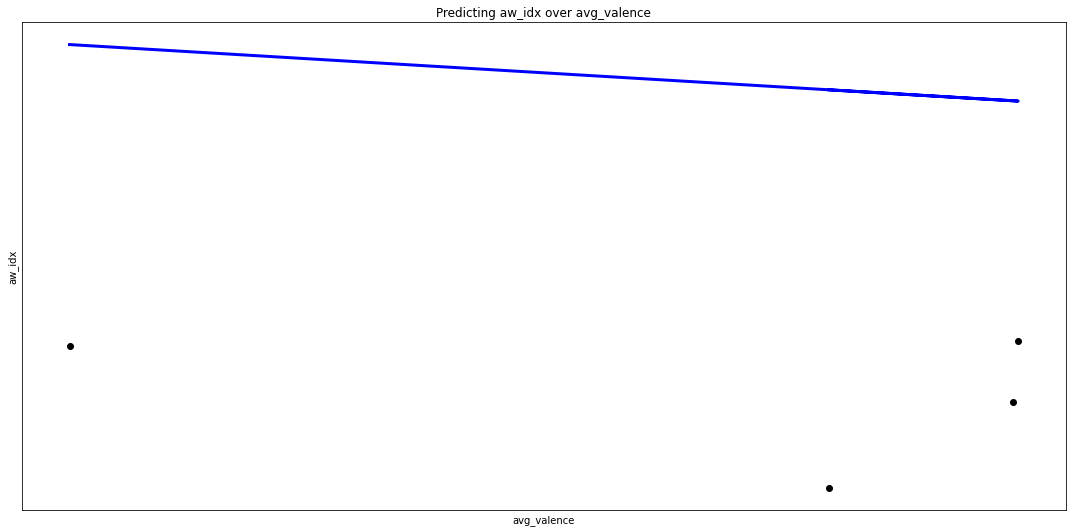

(0.001064130299606806, array([[-0.0154771]]), -27.29515975029326)

In [18]:
# https://stackoverflow.com/questions/40941542/using-scikit-learn-linearregression-to-plot-a-linear-fit
plt.rcParams["figure.figsize"] = [15, 7.50]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

### Automated Analysis
Now that we have the methods, we can automate the linear regression for all conditions and all classes

Analyzing condition EC for class_1_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.01766296]]
Mean squared error: 0.01
Coefficient of determination: -0.04


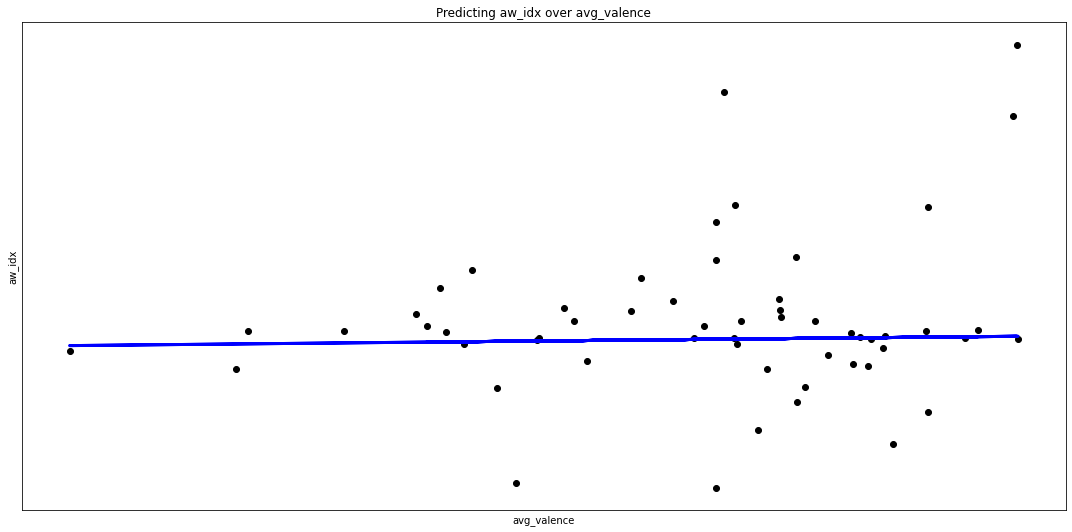

Analyzing condition EC for class_2_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.03280256]]
Mean squared error: 0.01
Coefficient of determination: -0.20


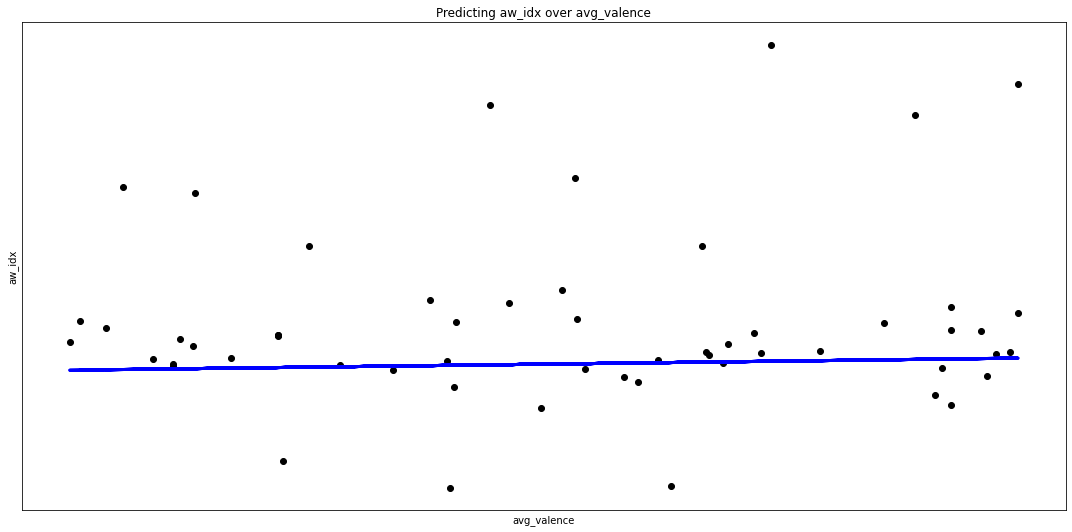

Analyzing condition EC for class_3_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.02772099]]
Mean squared error: 0.01
Coefficient of determination: -0.12


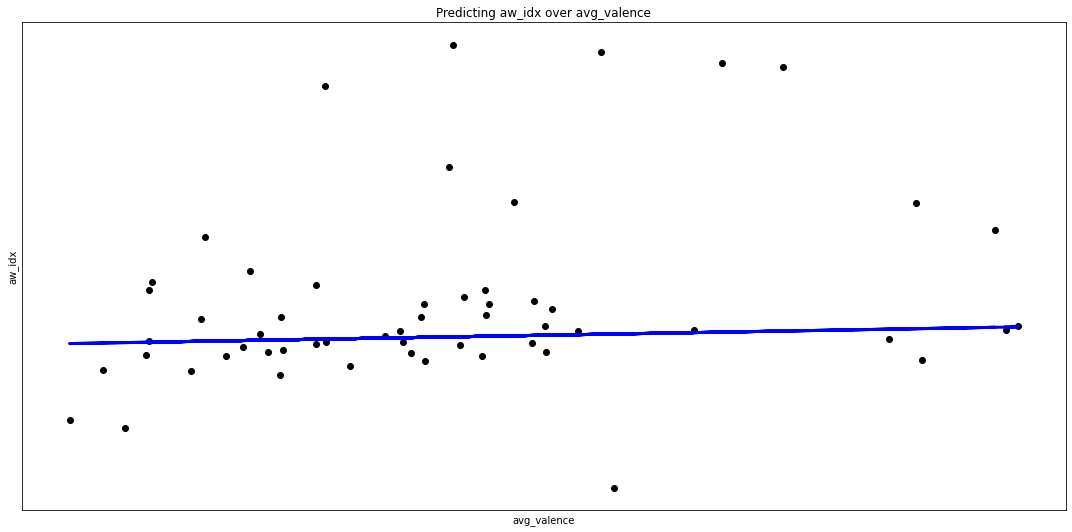

Analyzing condition EC for class_4_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.04164274]]
Mean squared error: 0.01
Coefficient of determination: -0.11


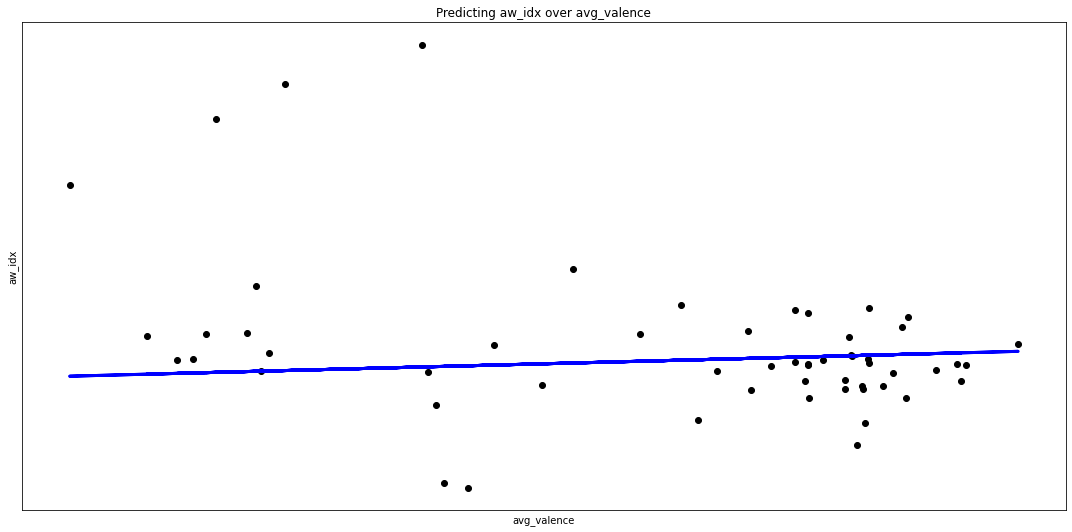

Analyzing condition EO for class_1_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.06820659]]
Mean squared error: 0.01
Coefficient of determination: -0.13


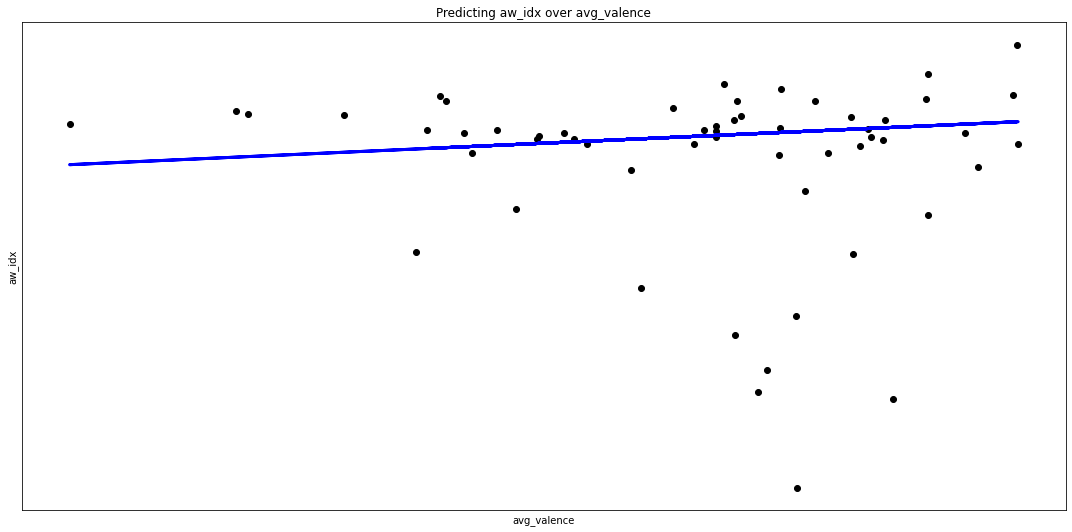

Analyzing condition EO for class_2_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.06139344]]
Mean squared error: 0.01
Coefficient of determination: -0.01


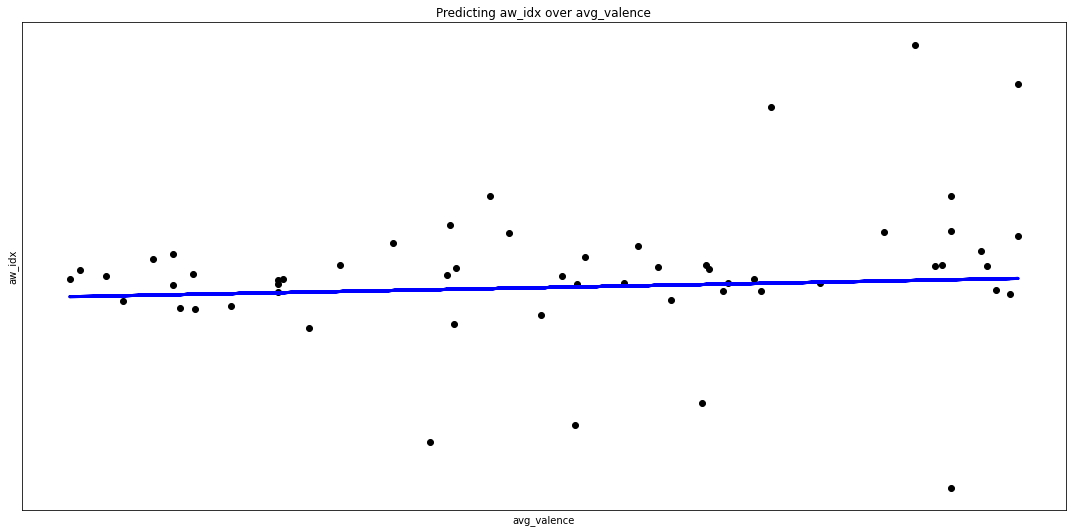

Analyzing condition EO for class_3_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.00290055]]
Mean squared error: 0.01
Coefficient of determination: -0.03


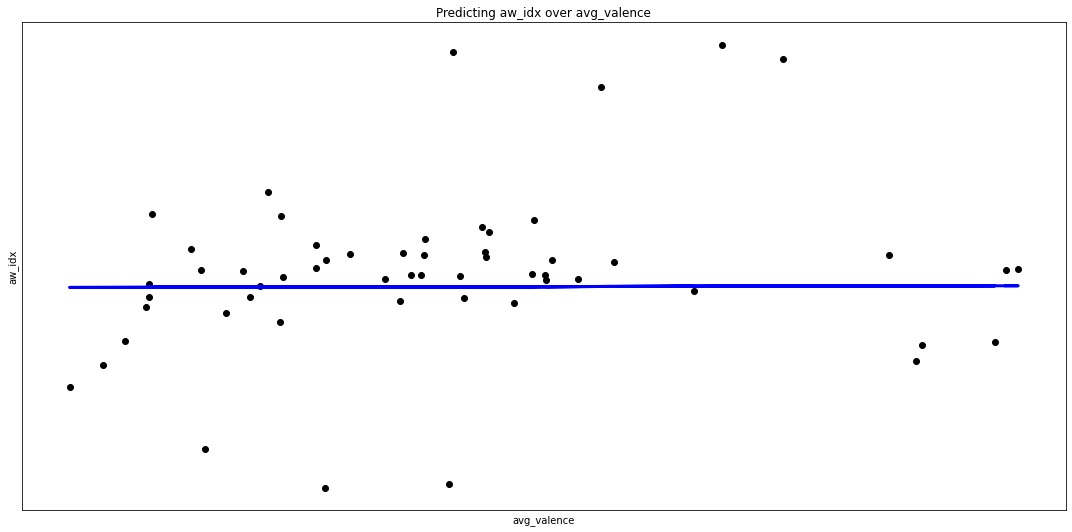

Analyzing condition EO for class_4_
Prediction with aw_idx as dependent variable and avg_valence as independent variable
Coefficients: 
 [[0.02261505]]
Mean squared error: 0.01
Coefficient of determination: -0.04


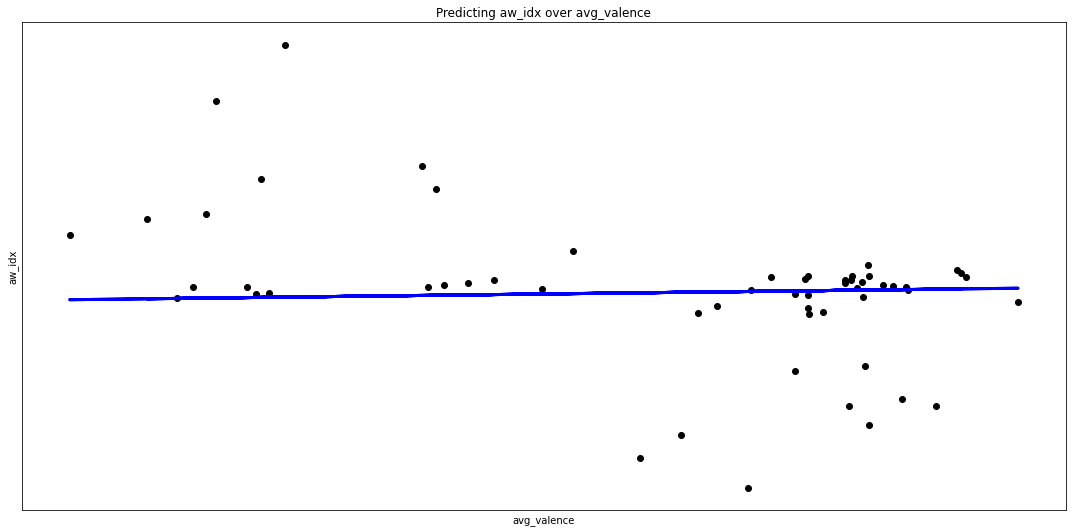

In [35]:
# AW Index with Valence
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'avg_valence'
dependent = 'aw_idx'
for condition in conditions:
    for trial_class in trial_classes:
        print("Analyzing condition " + condition + " for " + trial_class)
        x_train, y_train, x_test, y_test = valence_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

Analyzing condition EC for class_1_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.06623806]]
Mean squared error: 0.01
Coefficient of determination: -0.06


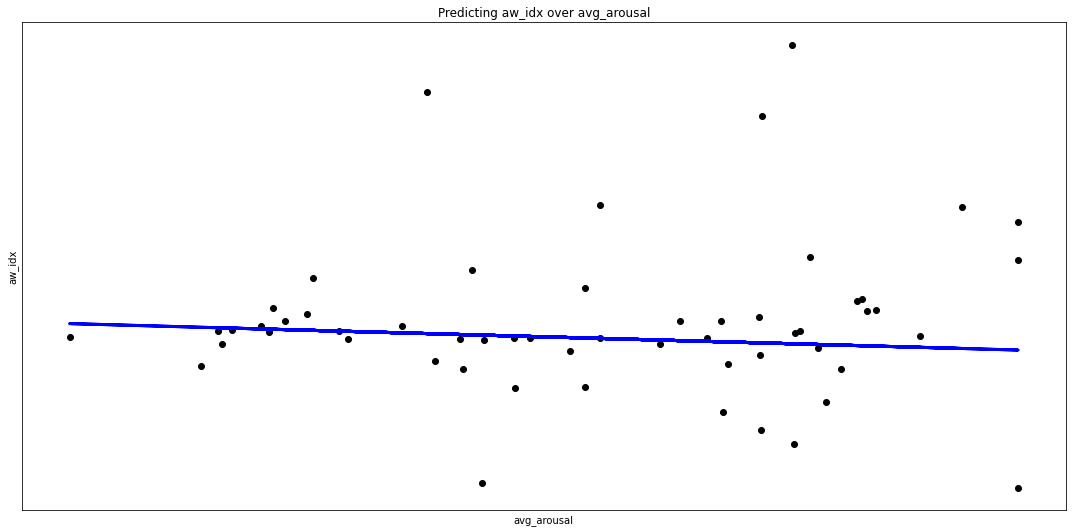

Analyzing condition EC for class_2_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.05629864]]
Mean squared error: 0.01
Coefficient of determination: -0.20


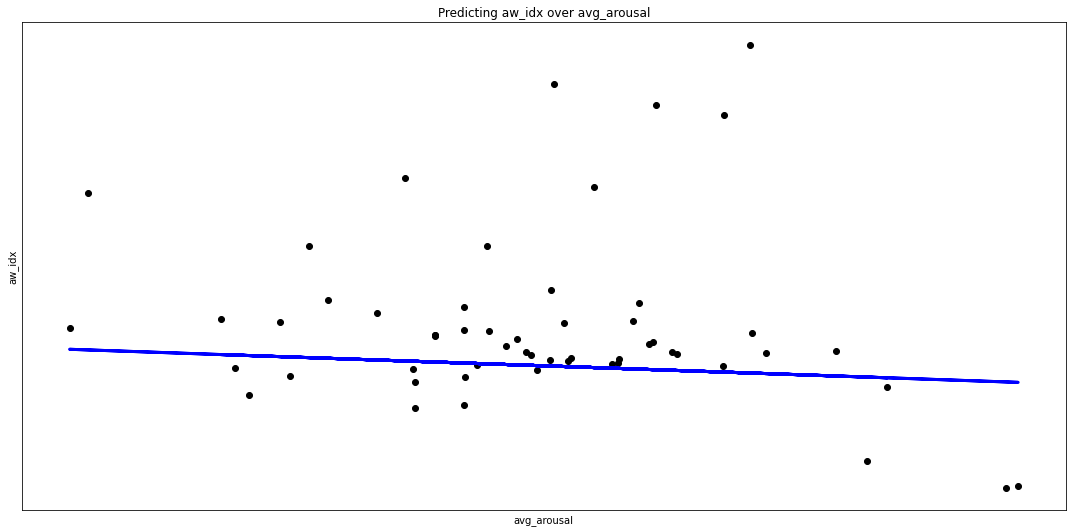

Analyzing condition EC for class_3_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.07129659]]
Mean squared error: 0.01
Coefficient of determination: -0.15


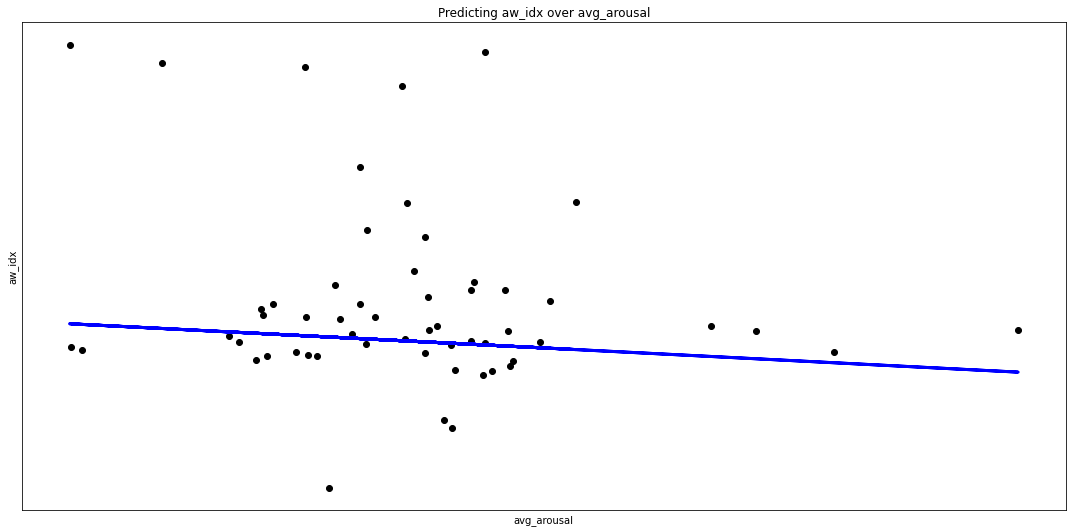

Analyzing condition EC for class_4_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[0.02891672]]
Mean squared error: 0.01
Coefficient of determination: -0.05


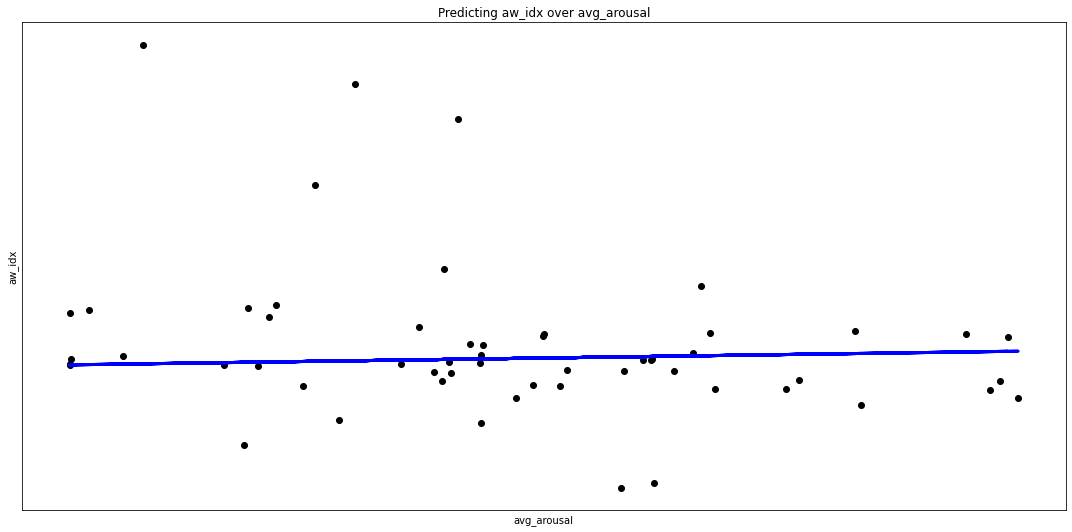

Analyzing condition EO for class_1_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.03461389]]
Mean squared error: 0.01
Coefficient of determination: -0.08


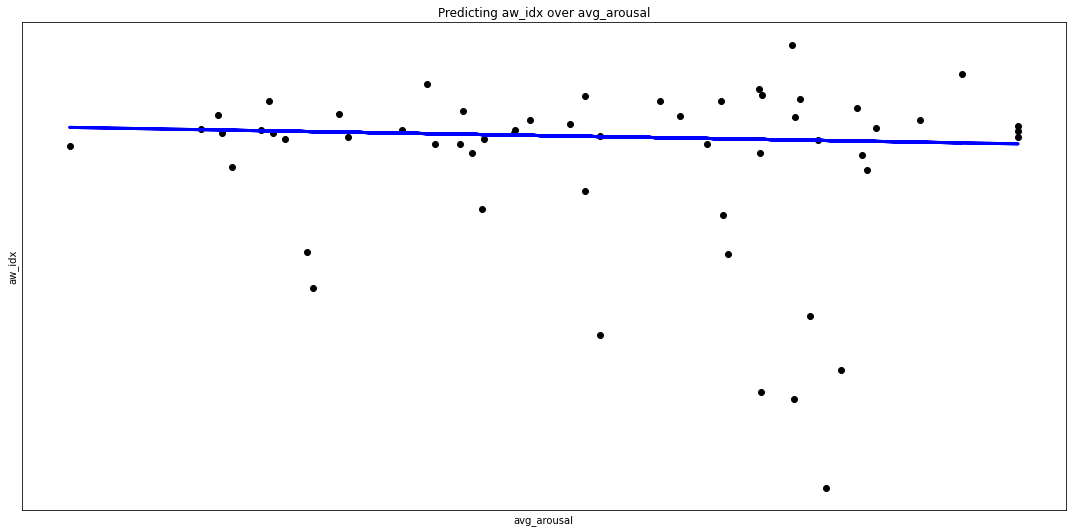

Analyzing condition EO for class_2_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[0.01235052]]
Mean squared error: 0.01
Coefficient of determination: -0.04


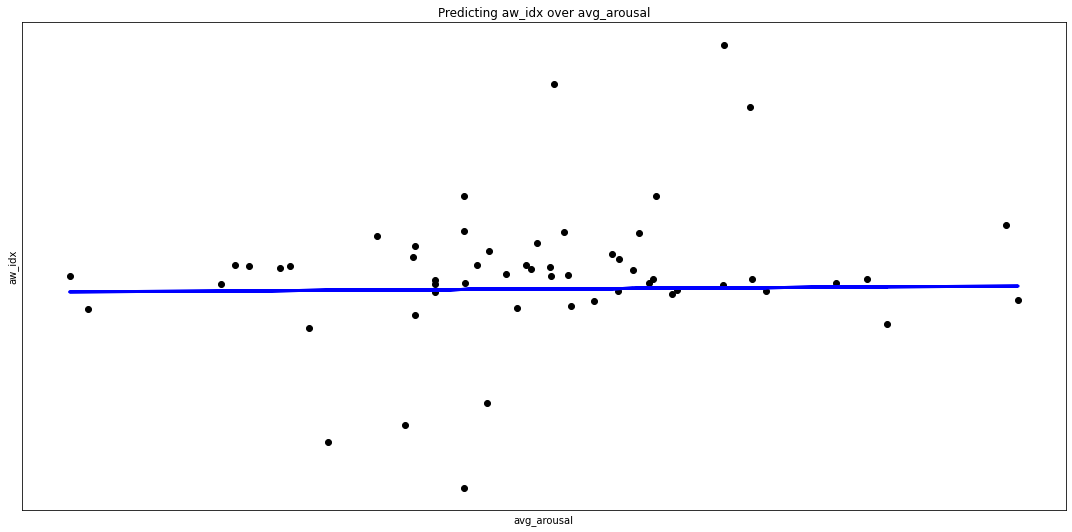

Analyzing condition EO for class_3_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[-0.00508294]]
Mean squared error: 0.01
Coefficient of determination: -0.03


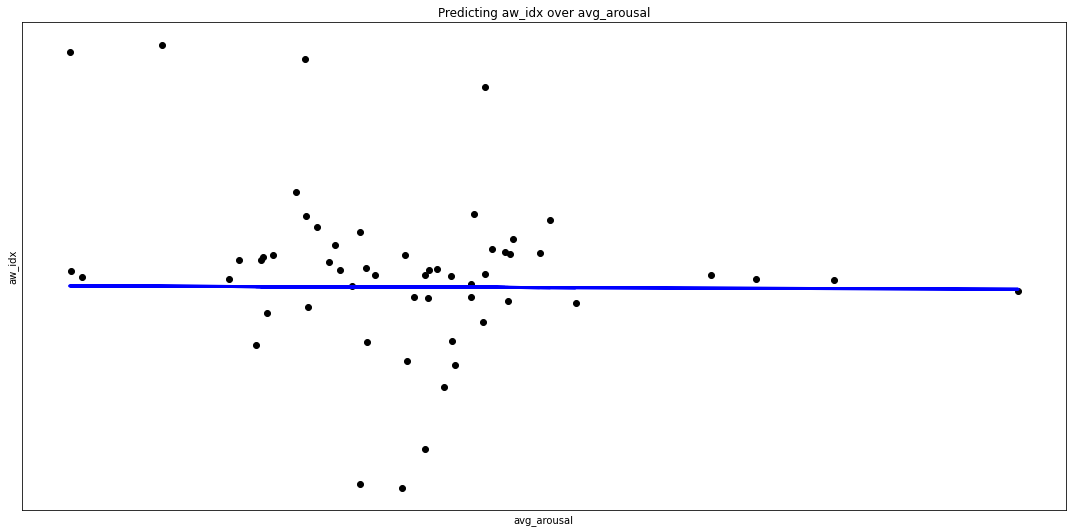

Analyzing condition EO for class_4_
Prediction with aw_idx as dependent variable and avg_arousal as independent variable
Coefficients: 
 [[0.00870967]]
Mean squared error: 0.01
Coefficient of determination: -0.00


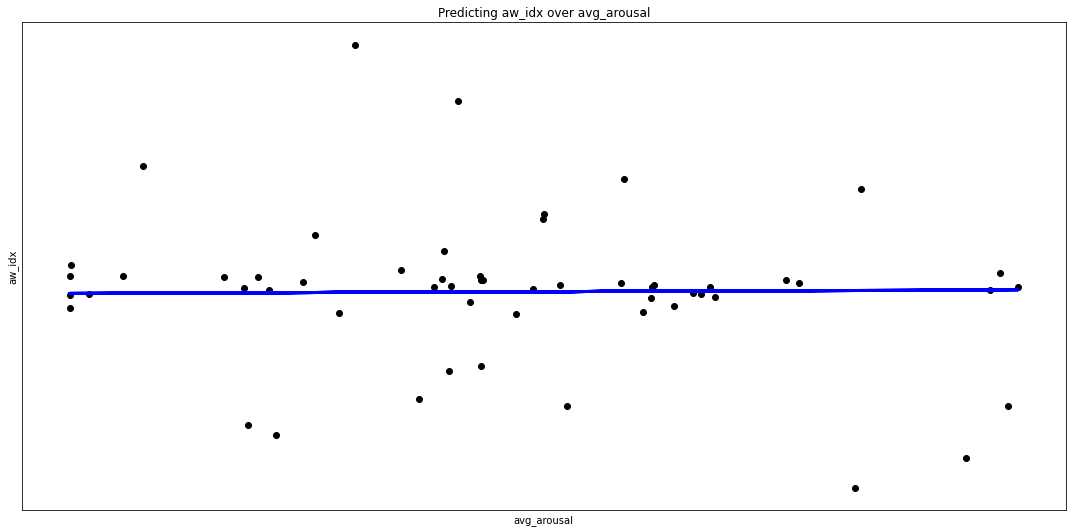

In [36]:
# AW Index with Arousal
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'avg_arousal'
dependent = 'aw_idx'
for condition in conditions:
    for trial_class in trial_classes:
        print("Analyzing condition " + condition + " for " + trial_class)
        x_train, y_train, x_test, y_test = arousal_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

In [ ]:
# Liking and familiarity
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'familiarity'
dependent = 'liking'
for condition in conditions:
    for trial_class in trial_classes:
        print("Analyzing dependent variable " + dependent + " in correlation with indepentent variable " + independent + " with condition " + condition + " for " + trial_class)
        x_train, y_train, x_test, y_test = liking_familiarity_correlation(prep_dataset, train_participants, test_participants, condition, trial_class, dependent, independent)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=True)

In [ ]:
# Find worst participants
participant_keys = [*prep_dataset]
#np.random.shuffle(participant_keys)
train_participants = participant_keys[:-7]
test_participants = participant_keys[-7:]

plt.rcParams["figure.figsize"] = [15, 7.50]
dependent = 'aw_idx'
conditions = ['EC', 'EO']
trial_classes = ['class_1_', 'class_2_', 'class_3_', 'class_4_']
independent = 'avg_valence'
dependent = 'aw_idx'
condition = 'EC'
trial_class = 'class_2_'
for participant in prep_dataset:
    train_participants = participant_keys.copy()
    train_participants.remove(participant)
    test_participants = [participant]
    x_train, y_train, x_test, y_test = valence_and_neuromarker(prep_dataset=prep_dataset, train_participants=train_participants, test_participants=test_participants, trial_class=trial_class, condition=condition, neuromarker=dependent)
    x_train = x_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    msq, coef, r2 = lin_regression(x_train, y_train, x_test, y_test, d_label=dependent, i_label=independent, plot=False)
    print(participant, "Coeff:", coef)